In [1]:
import numpy as np
import matplotlib.pyplot as plt

### code for Newton's method for midpoint rule ###
# z = (u,v,x,y)

# first derivative
def func(z):
    den = (z[2]**2 + z[3]**2)**(3/2)
    return np.array([-z[2]/den, -z[3]/den, z[0], z[1]])

# Jacobian of f
def Jac(z):
    # precomputed denominator
    den = (z[2]**2+z[3]**2)**(5/2)
    # fill in initially with zeros
    Df = np.zeros((4,4))
    Df[2,0] = 1
    Df[3,1] = 1
    Df[0,2] = (2*z[2]**2-z[3]**2)/den
    Df[0,3] = 3*z[2]*z[3]/den
    Df[1,2] = 3*z[2]*z[3]/den
    Df[1,3] = (2*z[3]**2-z[2]**2)/den
    return Df

# use Newton's method to compute k where
#  k = f(z + h*k/2)
itermax = 20
tol = 1.0e-14
def MidpointStep(z,h):
    # init (I - h/2 * Df(z))k = f(z)
    k = np.linalg.solve(np.eye(4) - h/2*Jac(z),func(z))
    # iterate
    for i in range(itermax):
        F = k - func(z+h/2*k)
        DF = np.eye(4) - h/2*Jac(z+h/2*k)
        k = k - np.linalg.solve(DF,F)
        # check value
        if np.linalg.norm(k-func(z+h/2*k)):
            break
    return z+h*k

# Developed step method
def StoermerVerletStep(z,h):
    # get p_{n+half} (u and v)
    f = func(z)
    aux = np.array(z)
    aux[:2] = aux[:2] + h/2*f[:2]
    # get q_{n+1} (x and y)
    f = func(aux)
    aux[2:] = aux[2:] + h*f[2:]
    # get p_{n+1}
    f = func(aux)
    aux[:2] = aux[:2] + h/2*f[:2]
    return aux

0.005081479771366526
4.900006001684609e-05
4.898265693054071e-07
Wall time: 13 s


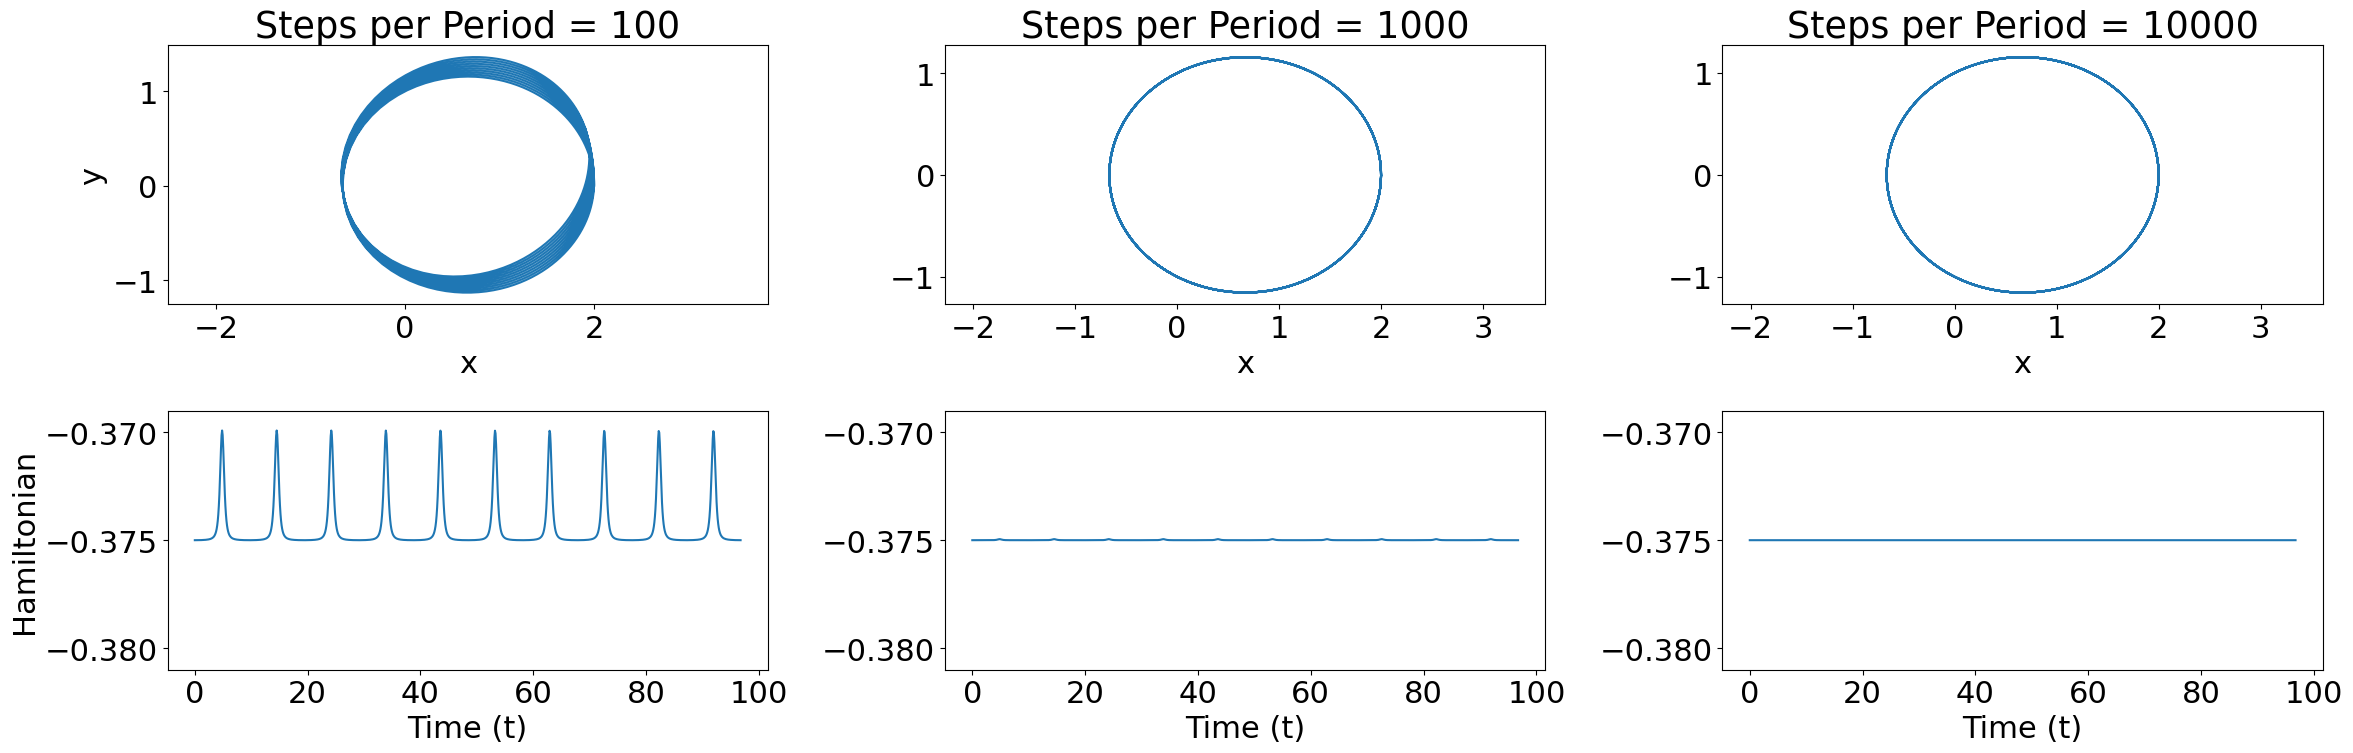

In [2]:
%%time
# some initial things
z0 = np.array([0,1/2,2,0])
Period = 9.673596609249161
Tmax = 10*Period
# initial fig
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2,3,figsize=(24,8))

for (j,StepsPerPeriod) in enumerate([100,1000,10000]):
    NSteps = StepsPerPeriod*10
    h = Period/StepsPerPeriod

    # time array
    t = np.arange(0,Tmax+h,h)
    sol = np.zeros((4,NSteps+1))

    sol[:,0] = z0
    for k in range(NSteps):
        sol[:,k+1] = MidpointStep(sol[:,k],h)

    axs[0,j].set_title('Steps per Period = ' + str(StepsPerPeriod))
    axs[0,j].plot(sol[2,:],sol[3,:])
    axs[0,j].axis('equal')
    axs[0,j].set_xlabel('x')
    
    # Hamiltonian H = u^2/2 + v^2 - 1/sqrt(x^2+y^2)
    H = (sol[0,:]**2)/2 + (sol[1,:]**2)/2 - 1/np.sqrt(sol[2,:]**2 + sol[3,:]**2)
    axs[1,j].plot(t,H)
    axs[1,j].set_ylim([-.381,-.369])
    axs[1,j].set_xlabel('Time (t)')
    
    print(max(abs(H+.375)))
    
axs[0,0].set_ylabel('y')
axs[1,0].set_ylabel('Hamiltonian')
plt.tight_layout()
plt.savefig('midpoint_sol.pdf')

0.003870862300499933
3.947057392461595e-05
3.947834055217925e-07
Wall time: 2.21 s


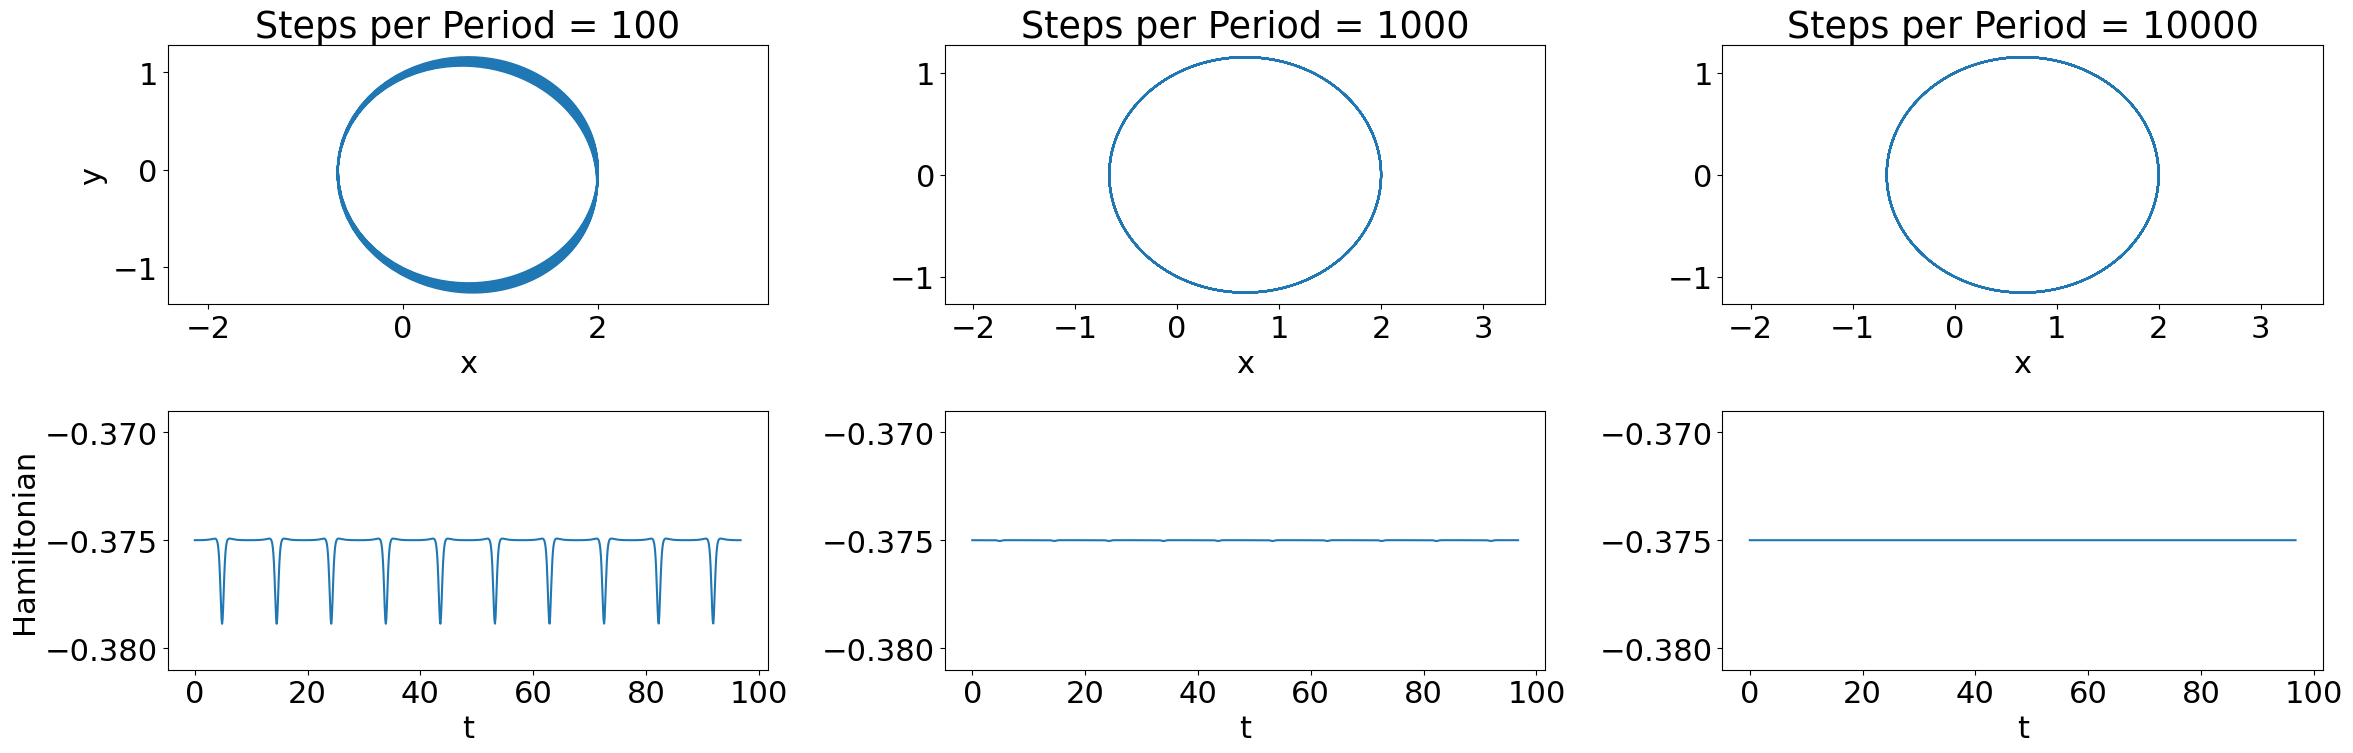

In [3]:
%%time
# some initial things
z0 = np.array([0,1/2,2,0])
Period = 9.673596609249161
Tmax = 10*Period
# initial fig
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(2,3,figsize=(24,8))

for (j,StepsPerPeriod) in enumerate([100,1000,10000]):
    NSteps = StepsPerPeriod*10
    h = Period/StepsPerPeriod

    # time array
    t = np.arange(0,Tmax+h,h)
    sol = np.zeros((4,NSteps+1))

    sol[:,0] = z0
    for k in range(NSteps):
        sol[:,k+1] = StoermerVerletStep(sol[:,k],h)
    
    axs[0,j].set_title('Steps per Period = ' + str(StepsPerPeriod))
    axs[0,j].plot(sol[2,:],sol[3,:])
    axs[0,j].axis('equal')
    axs[0,j].set_xlabel('x')
    
    # Hamiltonian H = u^2/2 + v^2 - 1/sqrt(x^2+y^2)
    H = (sol[0,:]**2)/2 + (sol[1,:]**2)/2 - 1/np.sqrt(sol[2,:]**2 + sol[3,:]**2)
    axs[1,j].plot(t,H)
    axs[1,j].set_ylim([-.375 - .006,-.375 + .006])
    axs[1,j].set_xlabel('t')
    
    print(max(abs(H+.375)))

axs[0,0].set_ylabel('y')
axs[1,0].set_ylabel('Hamiltonian')
plt.tight_layout()
plt.savefig('StoermerVerlet_sol.pdf')

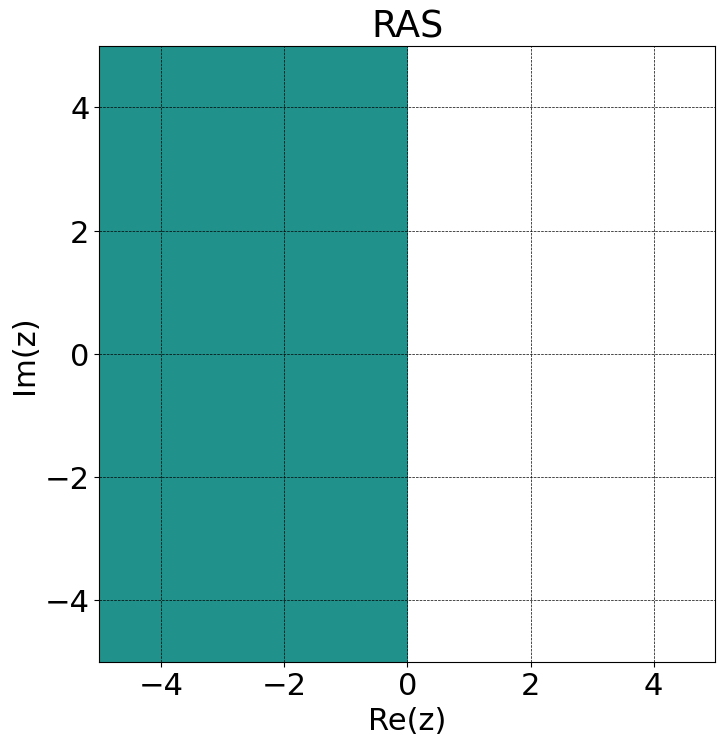

In [17]:
# Compute the region of absolute stability for implicit midpoint rule
# adapted from ODEsolver notes

# stability function
R = lambda z: (1+z/2)/(1-z/2)

# Construct a mesh
nx = 500
ny = 500
x = np.linspace(-5,5,nx)
y = np.linspace(-5,5,ny)
xg,yg = np.meshgrid(x,y)

# Evaluate
z = xg + 1j*yg
f = R(z)
absf = (((f.real)**2 + (f.imag)**2) < 1) # set unstable region to 2, stable to 0

# plot
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(8,8))
plt.contourf(xg,yg,absf,[0.5,1])
plt.title("RAS")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
ax.set_aspect(1)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.savefig('ImpMid_RAS.pdf')